In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import train_test_split
import torch

import numpy as np

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/anaconda3/envs/ONE/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
# rating: 1 = bad, 2 = good
def read_data(root, directory, file, rows=None):
    df = pd.read_csv(os.path.join(root, directory, file), header=None, nrows=rows)
    df.columns = ['review', 'rating']
    df['len'] = df['review'].apply(lambda x: len(x))
    return df

In [3]:
root = '/Users/ivoliv/data/yelp/YELP_BINARY'

df_train_orig = read_data(root, 'training', 'YELP_BINARY__FULL.csv', 56000)
df_test = read_data(root, 'eval', 'YELP_BINARY__TEST.csv', 3800)

In [4]:
df_train_orig.shape, df_test.shape

((56000, 3), (3800, 3))

In [5]:
df_train_orig[:5]

,review,rating,len
0,"Unfortunately, the frustration of being Dr. Go...",1,643
1,Been going to Dr. Goldberg for over 10 years. ...,2,495
2,I don't know what Dr. Goldberg was like before...,1,1143
3,I'm writing this review to give you a heads up...,1,1050
4,All the food is great here. But the best thing...,2,425


In [6]:
df_train_orig['review'][0], df_train_orig['rating'][0]

("Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars.",
 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20dd3f98>,
      dtype=object)

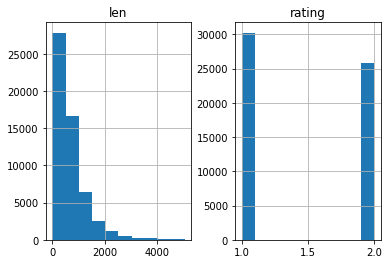

In [7]:
df_train_orig.hist()

In [8]:
# Splitting the subset to create new train and val
X_train, X_val = train_test_split(np.asarray([*df_train_orig.index]), test_size=0.1, random_state=123,
                                  shuffle=True, stratify=[*df_train_orig['rating']])

In [9]:
df_train = df_train_orig[df_train_orig.index.isin(X_train)]
df_val = df_train_orig[df_train_orig.index.isin(X_val)]

In [10]:
df_train.shape, df_val.shape, df_test.shape

((50400, 3), (5600, 3), (3800, 3))

(array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20e49e80>,
       dtype=object),
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a23ebae48>,
       dtype=object))

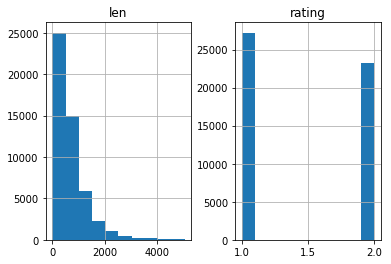

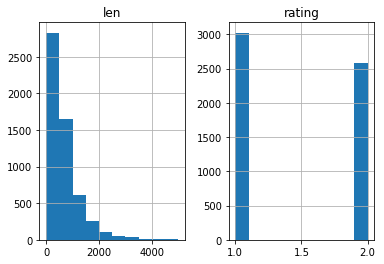

In [11]:
df_train.hist(), df_val.hist()

In [12]:
pd.set_option('mode.chained_assignment', None)
df_train['split'] = 'train'
df_val['split'] = 'val'
df_test['split'] = 'test'
final_reviews = pd.concat([df_train, df_val, df_test])
final_reviews.reset_index(inplace=True)

In [13]:
final_reviews[:5]

,index,review,rating,len,split
0,0,"Unfortunately, the frustration of being Dr. Go...",1,643,train
1,1,Been going to Dr. Goldberg for over 10 years. ...,2,495,train
2,2,I don't know what Dr. Goldberg was like before...,1,1143,train
3,3,I'm writing this review to give you a heads up...,1,1050,train
4,4,All the food is great here. But the best thing...,2,425,train


In [14]:
final_reviews['split'].value_counts()

train    50400
val       5600
test      3800
Name: split, dtype: int64

In [15]:
text = final_reviews['review'][0]
text

"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff.  It seems that his staff simply never answers the phone.  It usually takes 2 hours of repeated calling to get an answer.  Who has time for that or wants to deal with it?  I have run into this problem with many other doctors and I just don't get it.  You have office workers, you have patients with medical needs, why isn't anyone answering the phone?  It's incomprehensible and not work the aggravation.  It's with regret that I feel that I have to give Dr. Goldberg 2 stars."

In [16]:
import re
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [17]:
preprocess_text(text)

'unfortunately , the frustration of being dr . goldberg s patient is a repeat of the experience i ve had with so many other doctors in nyc good doctor , terrible staff . it seems that his staff simply never answers the phone . it usually takes hours of repeated calling to get an answer . who has time for that or wants to deal with it ? i have run into this problem with many other doctors and i just don t get it . you have office workers , you have patients with medical needs , why isn t anyone answering the phone ? it s incomprehensible and not work the aggravation . it s with regret that i feel that i have to give dr . goldberg stars . '

In [18]:
final_reviews.review = final_reviews.review.apply(preprocess_text)

In [19]:
final_reviews[:5]

,index,review,rating,len,split
0,0,"unfortunately , the frustration of being dr . ...",1,643,train
1,1,been going to dr . goldberg for over years . i...,2,495,train
2,2,i don t know what dr . goldberg was like befor...,1,1143,train
3,3,i m writing this review to give you a heads up...,1,1050,train
4,4,all the food is great here . but the best thin...,2,425,train


## Save data to csv, same directory

In [20]:
final_reviews.to_csv(os.path.join(root, 'YELP_BINARY__ALL.csv'))

# Data is preped. Now begin building the datasets class, vectorization, and loaders.

# Dataset

In [21]:
from torch.utils.data import Dataset

In [22]:
class ReviewDataset(Dataset):
    
    def __init__(self, review_df, vectorizer):
        
        self.review_df = review_df
        self.vectorizer = vectorizer
        
        self.train_df = self.review_df[self.review_df.split == 'train']
        self.train_size = len(self.train_df)
        
        self.val_df = self.review_df[self.review_df.split == 'val']
        self.val_size = len(self.val_df)
        
        self.test_df = self.review_df[self.review_df.split == 'test']
        self.test_size = len(self.test_df)
        
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.val_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
    def set_split(self, split='train'):
        
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        """ Return the size of the (selected) data set
        """
        return self._target_size
    
    def get_text(self, index):
        return self._target_df.iloc[index]
    
    def __getitem__(self, index):
        
        """ Return the `index` item in the dataset
        In particular, from the indexed row, return:
        - review vector (x_data) 
        - rating index token (y_target)
        """
        
        row = self._target_df.iloc[index]
        
        review_vector = self.vectorizer.vectorize(row.review)
        
        rating_index = torch.tensor(self.vectorizer.ratings_vocab.lookup_token(row.rating)).view(1)
        
        return {'idx': index,
                'x_data': review_vector,
                'y_target': rating_index}
    
    def get_num_batches(self, batch_size):
        
        return len(self) // batch_size
    
    def get_vectorizer(self):
        
        return self._vectorizer

    @classmethod
    def load_dataset_and_make_vectorizer(cls, filename):
        
        review_df = pd.read_csv(filename)
        return cls(review_df, ReviewVectorizer.from_dataframe(review_df))

# Vocabulary, Vectorizer, Dataloader

## Vocab

In [23]:
class Vocabulary(object):
    
    def __init__(self, token_to_index=None, add_unk=True, unk_token='<UNK>'):
        
        if token_to_index is None:
            token_to_index = {}
        self._token_to_index = token_to_index
        
        self._index_to_token = {idx: token for idx, token in self._token_to_index.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
        
    def add_token(self, token):
        
        if token not in self._token_to_index:
            token_index = len(self)
            self._token_to_index[token] = token_index
            self._index_to_token[token_index] = token
        else:
            token_index = self._token_to_index[token]
            
        return token_index
        
    def lookup_token(self, token):
        
        if self._unk_token:
            return self._token_to_index.get(token, self.unk_index)
        else:
            return self._token_to_index[token]
    
    def lookup_index(self, index):
        
        if index in self._index_to_token:
            return self._index_to_token[index]
        else:
            raise KeyError('the index {} is not in the vocabulary'.format(index))
        
    def __len__(self):
        return len(self._token_to_index)
    
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)
    
    def to_serializable(self):
        return {'token_to_idx': self._token_to_index, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}
    
    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

In [24]:
vocab = Vocabulary()

In [25]:
vocab._token_to_index

{'<UNK>': 0}

In [26]:
vocab.add_token('word')

1

In [27]:
vocab._token_to_index

{'<UNK>': 0, 'word': 1}

In [28]:
vocab._index_to_token

{0: '<UNK>', 1: 'word'}

In [29]:
vocab.lookup_index(1)

'word'

In [30]:
vocab.lookup_token('word')

1

In [31]:
vocab.add_token('Word')

2

In [32]:
vocab._index_to_token

{0: '<UNK>', 1: 'word', 2: 'Word'}

In [33]:
print(vocab)

<Vocabulary(size=3)>


## Vectorizer

In [34]:
ex = final_reviews.iloc[0]
ex.review

'unfortunately , the frustration of being dr . goldberg s patient is a repeat of the experience i ve had with so many other doctors in nyc good doctor , terrible staff . it seems that his staff simply never answers the phone . it usually takes hours of repeated calling to get an answer . who has time for that or wants to deal with it ? i have run into this problem with many other doctors and i just don t get it . you have office workers , you have patients with medical needs , why isn t anyone answering the phone ? it s incomprehensible and not work the aggravation . it s with regret that i feel that i have to give dr . goldberg stars . '

In [35]:
class ReviewVectorizer(object):
    
    def __init__(self, reviews_vocab, ratings_vocab):
        
        self.reviews_vocab = reviews_vocab
        self.ratings_vocab = ratings_vocab
        
    def vectorize(self, text):
        
        vector = torch.zeros(len(self.reviews_vocab))
        for tok in text.split():
            index = self.reviews_vocab.lookup_token(tok)
            vector[index] = 1  # collapsed one-hot representation
        
        return torch.Tensor(vector)
            
    @classmethod
    def from_dataframe(cls, review_df):

        reviews_vocab = Vocabulary()
        ratings_vocab = Vocabulary(add_unk=False, 
                                   token_to_index={1: 0., 2: 1.})
        
        for row in review_df.iterrows():
            for tok in (row[1].review).split():
                reviews_vocab.add_token(tok)
                
        return cls(reviews_vocab, ratings_vocab)

In [36]:
vectorizer = ReviewVectorizer.from_dataframe(final_reviews)

In [37]:
vectorizer.reviews_vocab.lookup_token('unfortunately')

1

In [38]:
vectorizer.vectorize(final_reviews.iloc[0].review)[:100]

tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [39]:
vectorizer.vectorize(final_reviews.iloc[1].review)[:100]

tensor([0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [40]:
[vectorizer.reviews_vocab._index_to_token[i] for i in range(10)]

['<UNK>',
 'unfortunately',
 ',',
 'the',
 'frustration',
 'of',
 'being',
 'dr',
 '.',
 'goldberg']

In [41]:
len(vectorizer.vectorize(final_reviews.iloc[1].review))

63524

In [42]:
len(vectorizer.reviews_vocab)

63524

In [43]:
print(vectorizer.ratings_vocab)
vectorizer.ratings_vocab.to_serializable()

<Vocabulary(size=2)>


{'token_to_idx': {1: 0.0, 2: 1.0}, 'add_unk': False, 'unk_token': '<UNK>'}

## Dataloader

In [44]:
dataset = ReviewDataset.load_dataset_and_make_vectorizer(os.path.join(root, 'YELP_BINARY__ALL.csv'))
dataset.__getitem__(0)

{'idx': 0,
 'x_data': tensor([0., 1., 1.,  ..., 0., 0., 0.]),
 'y_target': tensor([0.])}

In [45]:
dataset.__getitem__(1)

{'idx': 1,
 'x_data': tensor([0., 0., 1.,  ..., 0., 0., 0.]),
 'y_target': tensor([1.])}

In [206]:
dataset.get_text(1)

Unnamed: 0                                                    1
index                                                         1
review        been going to dr . goldberg for over years . i...
rating                                                        2
len                                                         495
split                                                     train
Name: 1, dtype: object

In [46]:
from torch.utils.data import DataLoader

In [47]:
dataloader = DataLoader(dataset=dataset, batch_size=16,
                        shuffle=True, drop_last=False)

In [48]:
dataloader.batch_size

16

In [49]:
for i in dataloader:
    print(i)
    print(i['x_data'].shape, i['y_target'].shape)
    break

{'x_data': tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]]), 'y_target': tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]])}
torch.Size([16, 63524]) torch.Size([16, 1])


In [50]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device='cpu'):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
    ensure each tensor is on the right device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

# Simple fully connected classifier (MLP)

In [51]:
import torch.nn as nn

In [52]:
class ReviewClassifier(nn.Module):
    def __init__(self, num_features):
        super(ReviewClassifier, self).__init__()
        self.fc = nn.Linear(in_features=num_features, out_features=1)
    
    def forward(self, inputs, apply_sig=False):
        out = self.fc(inputs)
        if apply_sig:
            out = torch.sigmoid(out)
        return out

In [53]:
model = ReviewClassifier(len(vectorizer.reviews_vocab))
print(model)

ReviewClassifier(
  (fc): Linear(in_features=63524, out_features=1, bias=True)
)


In [54]:
model = model.to(device)

In [55]:
data_dict = next(iter(dataloader))

In [56]:
data_dict['x_data']

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [57]:
data_dict['y_target']

tensor([[1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]])

In [58]:
model(data_dict['x_data'])

tensor([[-0.0581],
        [-0.0432],
        [ 0.0047],
        [ 0.0085],
        [-0.0019],
        [ 0.0006],
        [ 0.0091],
        [-0.0111],
        [-0.0181],
        [ 0.0296],
        [-0.0333],
        [-0.0108],
        [-0.0195],
        [-0.0216],
        [-0.0030],
        [-0.0175]], grad_fn=<ThAddmmBackward>)

In [59]:
torch.cat([model(data_dict['x_data'], apply_sig=True), data_dict['y_target']], dim=1)

tensor([[0.4855, 1.0000],
        [0.4892, 1.0000],
        [0.5012, 0.0000],
        [0.5021, 0.0000],
        [0.4995, 1.0000],
        [0.5001, 0.0000],
        [0.5023, 0.0000],
        [0.4972, 0.0000],
        [0.4955, 1.0000],
        [0.5074, 0.0000],
        [0.4917, 1.0000],
        [0.4973, 1.0000],
        [0.4951, 0.0000],
        [0.4946, 0.0000],
        [0.4992, 1.0000],
        [0.4956, 0.0000]], grad_fn=<CatBackward>)

In [60]:
bce_loss = nn.BCEWithLogitsLoss()

In [61]:
y_pred = model(data_dict['x_data'], apply_sig=False)
loss = bce_loss(y_pred, data_dict['y_target'])
loss

tensor(0.6979, grad_fn=<MeanBackward1>)

### Static (single) batch

In [62]:
x_data = data_dict['x_data']
y_target = data_dict['y_target']

In [63]:
optim = torch.optim.Adam(model.parameters())
hist = []

In [64]:
for i in range(500):
    model.zero_grad()
    y_pred = model(x_data, apply_sig=False)
    loss = bce_loss(y_pred, y_target)
    loss.backward()
    diffs = abs(torch.sigmoid(y_pred) - y_target)
    acc = torch.sum(diffs < .5).item() / diffs.shape[0]
    hist.append([loss, acc])
    optim.step()
    if i > 0 and i % 50 == 0:
        print('{:0} : {:6.2} {:.1%}'.format(i, loss.item(), acc))
print('{:0} : {:6.2} {:.1%}'.format(i, loss.item(), acc))

50 :   0.16 100.0%
100 :  0.081 100.0%
150 :  0.052 100.0%
200 :  0.036 100.0%
250 :  0.027 100.0%
300 :  0.021 100.0%
350 :  0.017 100.0%
400 :  0.014 100.0%
450 :  0.012 100.0%
499 :   0.01 100.0%


In [65]:
diffs = abs(torch.sigmoid(y_pred) - y_target)
acc = torch.sum(diffs > .5e-5).item() / diffs.shape[0]
acc

1.0

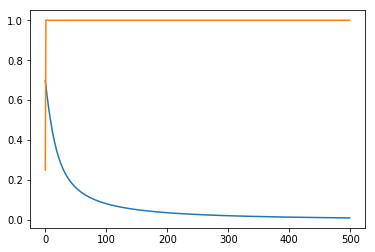

In [66]:
plt.plot(hist)

In [67]:
diffs

tensor([[0.0019],
        [0.0026],
        [0.0025],
        [0.0066],
        [0.0044],
        [0.0627],
        [0.0168],
        [0.0077],
        [0.0032],
        [0.0059],
        [0.0061],
        [0.0175],
        [0.0032],
        [0.0038],
        [0.0141],
        [0.0019]], grad_fn=<AbsBackward>)

In [68]:
data_dict = next(iter(dataloader))

In [69]:
x_data = data_dict['x_data']
y_target = data_dict['y_target']

In [70]:
y_pred = model(x_data, apply_sig=False)

In [71]:
torch.cat([torch.sigmoid(y_pred), y_target], dim=1)

tensor([[0.8210, 1.0000],
        [0.3904, 0.0000],
        [0.5075, 0.0000],
        [0.4997, 1.0000],
        [0.6106, 0.0000],
        [0.3474, 1.0000],
        [0.6321, 0.0000],
        [0.5620, 0.0000],
        [0.5228, 1.0000],
        [0.7896, 1.0000],
        [0.4609, 0.0000],
        [0.4123, 1.0000],
        [0.3717, 1.0000],
        [0.3008, 1.0000],
        [0.1786, 0.0000],
        [0.7059, 1.0000]], grad_fn=<CatBackward>)

In [72]:
bce_loss(y_pred, y_target)

tensor(0.6903, grad_fn=<MeanBackward1>)

# Multiple batches (SGD)

In [73]:
hist = []
import tqdm
batch_size = 32

In [74]:
def run_batch(model, run_type='train', dataset=None, 
              batch_size=None, shuffle=True, drop_last=False):
    
    dataset.set_split(run_type)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=True, drop_last=False)
    if run_type == 'train':
        model = model.train()
    else:
        model = model.eval()
    
    running_loss = 0
    running_acc = 0
    
    for batch_dict in tqdm.tqdm(dataloader):
        
        if model.training:
            model.zero_grad()
        
        x_data = batch_dict['x_data'].to(device)
        y_target = batch_dict['y_target'].to(device)
        
        y_pred = model(x_data)
        loss = bce_loss(y_pred, y_target)
        
        if model.training:
            loss.backward()
        
        diffs = abs(torch.sigmoid(y_pred) - y_target)
        acc = torch.sum(diffs < .5).item()
        
        running_loss += loss * batch_dict['x_data'].shape[0]
        running_acc += acc
        
        if model.training:
            optim.step()
        
    running_loss = running_loss / len(dataset)
    running_acc = running_acc / len(dataset)
    
    return running_loss, running_acc

In [76]:
for epoch in range(10):
    
    running_loss_train, running_acc_train = run_batch(model, run_type='train', 
                                                      dataset=dataset, batch_size=batch_size, 
                                                      shuffle=True, drop_last=False)
    
    running_loss_val, running_acc_val = run_batch(model, run_type='val', 
                                                  dataset=dataset, batch_size=batch_size, 
                                                  shuffle=True, drop_last=False)
    
    hist.append([running_loss_train, running_acc_train, running_loss_val, running_acc_val])
        
    print('{:0} : {:6.2} {:.1%} : {:6.2} {:.1%}'.format(epoch, running_loss_train, running_acc_train,
                                                               running_loss_val, running_acc_val))

  0%|          | 2/1575 [00:00<01:34, 16.69it/s]

0 :   0.21 93.0% :   0.22 92.1%


  0%|          | 2/1575 [00:00<01:37, 16.06it/s]

1 :   0.17 94.2% :   0.21 92.4%


  0%|          | 2/1575 [00:00<01:27, 17.89it/s]

2 :   0.15 95.0% :    0.2 92.5%


  0%|          | 2/1575 [00:00<01:34, 16.68it/s]

3 :   0.14 95.4% :    0.2 92.5%


  0%|          | 2/1575 [00:00<01:34, 16.67it/s]

4 :   0.13 95.9% :    0.2 92.3%


  0%|          | 2/1575 [00:00<01:26, 18.24it/s]

5 :   0.12 96.2% :    0.2 92.2%


  0%|          | 3/1575 [00:00<01:17, 20.24it/s]

6 :   0.11 96.5% :    0.2 92.5%


  0%|          | 2/1575 [00:00<01:26, 18.25it/s]

7 :    0.1 96.8% :   0.21 92.3%


  0%|          | 2/1575 [00:00<01:34, 16.72it/s]

8 :  0.099 97.0% :   0.21 92.2%


100%|██████████| 175/175 [00:08<00:00, 21.22it/s]

9 :  0.094 97.2% :   0.21 92.2%


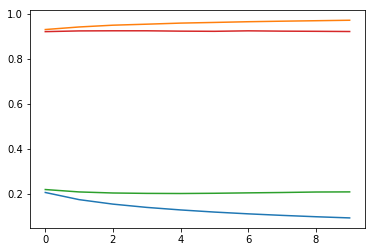

In [77]:
plt.plot(hist)

In [83]:
running_loss_test, running_acc_test = run_batch(model, run_type='test', 
                                                dataset=dataset, batch_size=batch_size, 
                                                shuffle=True, drop_last=False)

100%|██████████| 119/119 [00:05<00:00, 20.95it/s]


In [84]:
print(running_loss_test.item(), running_acc_test)

0.19227318465709686 0.9281578947368421


# Find incorrect test examples

In [264]:
dataset.set_split('test')
dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                        shuffle=True, drop_last=False)
model = model.eval()

In [265]:
batch = next(iter(dataloader))

In [266]:
idx = batch['idx']
x_data = batch['x_data'].to(device)
y_target = batch['y_target'].to(device)

In [267]:
idx

tensor([3018,  554, 1723, 2293, 1399, 2116, 3265, 3174, 1295, 1104, 1646,  298,
        1262,   23,  578, 3702, 2487,  188, 2962, 3673, 3601,  247, 1857, 2123,
        2039, 1711, 1970,  116, 2654,  601, 2698,  472])

In [268]:
y_pred = torch.sigmoid(model(x_data))

In [269]:
miss = torch.round(y_pred) != y_target

In [270]:
miss_list = list(miss.nonzero()[:,0].numpy())
miss_list

[0, 2, 3, 4]

In [271]:
idx_miss = list(idx[miss_list].numpy())
idx_miss

[3018, 1723, 2293, 1399]

In [272]:
for i, idx in enumerate(miss_list):
    print(dataset.get_text(idx_miss[i])['review'])
    print(y_pred[idx], y_target[idx])
    print()

i have used smw for many years for routine maintenance on my a c and heater . i knew the unit was old , but for years they have been repairing it as needed , until finally they gave me the opinion that it needed to be replaced . i had to wait a couple days for the scheduled replacement , and during that time the a c died completely . scott came out to my house in the evening , just to see if there was anything he could do to get an extra day or two , but no luck . they moved up my installation time , and there was no charge for the extra service visit . i love my new unit and would never consider using any other company for my a c needs . 
tensor([0.3086], grad_fn=<SelectBackward>) tensor([1.])

i strongly dislike this airport . i had to catch a connecting flight from phoenix to maui in another terminal . i had no idea i had to leave security , catch a bus , and then go through the tsa line again to get to the other terminal . i have an especially bitter taste in my mouth for sky harbo

In [281]:
def predict(text):
    pred = torch.round(torch.sigmoid(model(vectorizer.vectorize(text)))).item()
    if pred == 1:
        return 'positive'
    else:
        return 'negative'

In [289]:
predict('this is a pretty awesome book !')

'good'

# Since BOW, looks at weights of words

In [303]:
print(model)

ReviewClassifier(
  (fc): Linear(in_features=63524, out_features=1, bias=True)
)


In [300]:
fc_weights = model.fc.weight.detach().squeeze()
fc_weights

tensor([-0.0001, -1.0666,  0.0737,  ..., -0.0038, -0.0032,  0.0008])

In [322]:
_, indices = torch.sort(fc_weights, dim=0, descending=True)
indices = list(indices.numpy())
indices[:10]

[444, 768, 275, 736, 682, 4883, 645, 1515, 95, 1816]

In [321]:
for idx in indices[:10]:
    print(vectorizer.reviews_vocab.lookup_index(idx))

pleasantly
delicious
fantastic
excellent
amazing
ngreat
awesome
perfect
great
yummy


In [324]:
indices[-10:]

[3050, 2394, 1596, 28, 1426, 2180, 2989, 3134, 1977, 1433]

In [325]:
for idx in indices[-10:]:
    print(vectorizer.reviews_vocab.lookup_index(idx))

underwhelmed
slowest
rude
terrible
awful
horrible
meh
mediocre
bland
worst
